# Imports

Toggle cells below if you want to see what imports are being made.

In [2]:
#|code-fold: true
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Data

Let's create 100 `x` values uniformly distributed between 0 and 100. Note the usage of a random seed for reproducibility:

In [3]:
np.random.seed(0)
x = np.random.uniform(0, 100, size=100)

Calculate `y` values for the given `x` values. I chose a slope of -2 and an intercept of 10 and decided not to add noise to make the task easier:

In [4]:
slope = -2
intercept = 10
y = slope * x + intercept

Let's plot the points to check that everything looks as it should be:

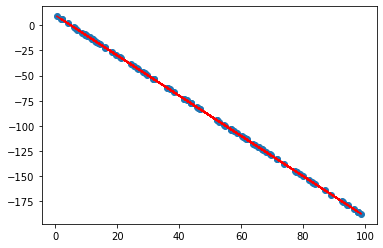

In [5]:
plt.scatter(x, y)
plt.plot(x, slope * x + intercept, color="red");

# Prepare for the experiments

Let's create some classes and functions that will help us to quickly experiment with different optimization algorithms.

We start by creating our simple `LinearModel` whose parameters we'll try to optimize. Here we choose to initialize both the slope and the intercept with the value `1`, but this should not matter too much for this problem.

The `forward` method performs the forward pass of the model to get a prediction for a given `x`, i.e. just return `ax+b`.

The `backward` method is used to calculate gradients of the parameters given `x`, `y` and `y_pred`. These are usually calculated using automatic differentiation in deep learning libraries, such as PyTorch, but here we do everything by hand:

In [6]:
class LinearModel:
    def __init__(self, initial_slope=1, initial_intercept=1):
        self.slope = initial_slope
        self.intercept = initial_intercept
    
    def forward(self, x):
        return self.slope * x + self.intercept
    
    def backward(self, x, y, y_pred):
        return x * (y_pred - y), (y_pred - y)

The `Tracker` utility class will be used to track different values while experimenting. It can be considered an overkill for such a simple task (and I later ended up tracking only one value with it), but it can be very convenient for larger projects, so I included it here too.

The class stores a dictionary of `string-list` pairs in its state and provides `add_record` and `get_values` methods to easily access and update that dictionary.

In [7]:
from collections import defaultdict

class Tracker:
    def __init__(self):
        self.tracker = defaultdict(list)
    
    def add_record(self, key, value):
        self.tracker[key].append(value)
    
    def get_values(self, key):
        if not key in self.tracker: raise KeyError(f"Key {key} not in tracker")

        return self.tracker[key]

`train_one_epoch` is a utility function that trains the model for one epoch (one pass through the data). It performs a forward pass, calculates and tracks the error, gets the gradients of parameters by performing a backward pass and passes those along with the `params` parameter to the optimizer that updates the weights of the model. The `params` parameter is a dictionary that is used to hyperparameter constants, such as the learning rate, to the optimizer.

In [8]:
def train_one_epoch(model, data, optimizer, tracker, params):
    total_error = 0.0
    
    for x, y in data:
        # Forward pass
        y_pred = model.forward(x)
        
        # Calculate error
        error = 0.5 * (y_pred - y) ** 2
        total_error += error

        # Backward pass
        grad_slope, grad_intercept = model.backward(x, y, y_pred)
        
        # Step the optimizer
        params["step"] += 1
        optimizer.step(model, grad_slope, grad_intercept, params)

    tracker.add_record("error", total_error / len(data))

Finally, a utility function that brings everything together to execute an experiment. Our goal is to train the model for as little as possible, stopping when error drops below some desired threshold.

In [9]:
def perform_experiment(optimizer, params, desired_error=1e-8):
    # Initialization
    model = LinearModel()
    data = list(zip(x, y))
    tracker = Tracker()
    
    params["step"] = 0
    while True:
        # Train for an epoch
        train_one_epoch(model, data, optimizer, tracker, params)
        
        # Check if we reached desired accuracy
        if tracker.get_values("error")[-1] <= desired_error:
            break
        
        # Improper hyperparameter values might cause the models to diverge,
        # so we include this here to stop execution if this happens
        if np.isnan(tracker.get_values("error")[-1]):
            break
    
    # Print results and plot error over time
    steps = params["step"]
    print(f"Epochs: {steps // len(data)}")
    print(f"Batches (of size 1): {steps}")
    print(f"Slope: {model.slope}")
    print(f"Intercept: {model.intercept}")
    plt.plot(tracker.get_values("error"), linestyle="dotted")
    
    return params["step"] // len(data), params["step"], model.slope, model.intercept

# Vanilla SGD

In [10]:
class SGDOptimizer:
    def step(self, model, grad_slope, grad_intercept, params):
        lr = params["lr"]
        model.slope -= lr * grad_slope
        model.intercept -= lr * grad_intercept

Epochs: 3893
Batches (of size 1): 389300
Slope: -1.9999963788900519
Intercept: 9.999738575620166


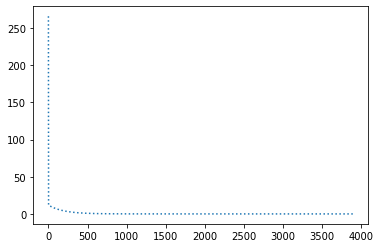

In [11]:
optimizer = SGDOptimizer()
params = { "lr": 1e-4 }
perform_experiment(optimizer, params);

Breaks with `lr=1e-3`

# SGD with momentum

In [12]:
class SGDWithMomentumOptimizer(SGDOptimizer):
    def __init__(self):
        self.slope_momentum = self.intercept_momentum = 0
    
    def step(self, model, grad_slope, grad_intercept, params):
        lr = params["lr"]
        miu = params["miu"]
        self.slope_momentum = miu * self.slope_momentum + (1 - miu) * grad_slope
        model.slope -= lr * self.slope_momentum

        self.intercept_momentum = miu * self.intercept_momentum + (1 - miu) * grad_intercept
        model.intercept -= lr * self.intercept_momentum

Epochs: 3844
Batches (of size 1): 384400
Slope: -1.9999951526911044
Intercept: 9.999742134759243


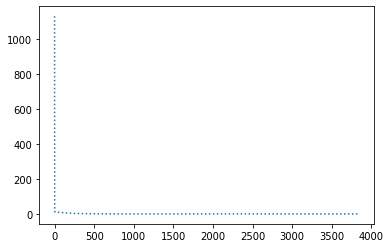

In [13]:
optimizer = SGDWithMomentumOptimizer()
params = { "lr": 1e-4, "miu": 0.9 }
perform_experiment(optimizer, params);

Epochs: 365
Batches (of size 1): 36500
Slope: -1.9999980020599053
Intercept: 9.999929876584854


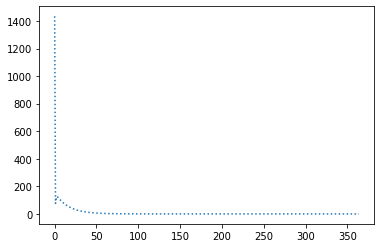

In [14]:
optimizer = SGDWithMomentumOptimizer()
params = { "lr": 1e-3, "miu": 0.9 }
perform_experiment(optimizer, params);

# RMSprop

In [15]:
class RMSpropOptimizer(SGDOptimizer):
    def __init__(self, eps=1e-8):
        self.eps = eps
        self.slope_squared_grads = self.intercept_squared_grads = 0
    
    def step(self, model, grad_slope, grad_intercept, params):
        lr = params["lr"]
        decay_rate = params["decay_rate"]
        self.slope_squared_grads = decay_rate * self.slope_squared_grads + (1 - decay_rate) * grad_slope ** 2
        model.slope -= lr * grad_slope / (np.sqrt(self.slope_squared_grads) + self.eps)

        self.intercept_squared_grads = decay_rate * self.intercept_squared_grads + (1 - decay_rate) * grad_intercept ** 2
        model.intercept -= lr * grad_intercept / (np.sqrt(self.intercept_squared_grads) + self.eps)

Epochs: 2765
Batches (of size 1): 276500
Slope: -1.9999999858447193
Intercept: 9.999996406289089


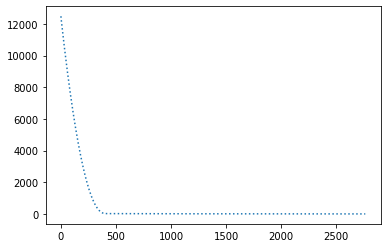

In [16]:
optimizer = RMSpropOptimizer()
params = { "lr": 1e-4, "decay_rate": 0.99 }
perform_experiment(optimizer, params);

Epochs: 302
Batches (of size 1): 30200
Slope: -1.9999998782649515
Intercept: 9.999976783670757


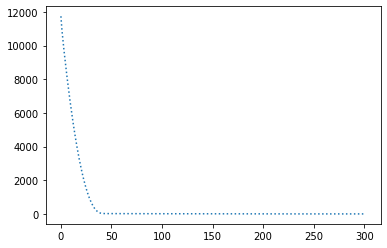

In [17]:
optimizer = RMSpropOptimizer()
params = { "lr": 1e-3, "decay_rate": 0.99 }
perform_experiment(optimizer, params);

Epochs: 113
Batches (of size 1): 11300
Slope: -2.0000001115561656
Intercept: 10.000020816756175


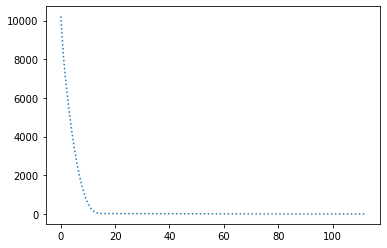

In [18]:
optimizer = RMSpropOptimizer()
params = { "lr": 3e-3, "decay_rate": 0.99 }
perform_experiment(optimizer, params);

Works best with `lr=3e-3` and `decay_rate=0.99`.

Epochs: 83323
Batches (of size 1): 8332300
Slope: -2.000000169655216
Intercept: 10.000030570050711


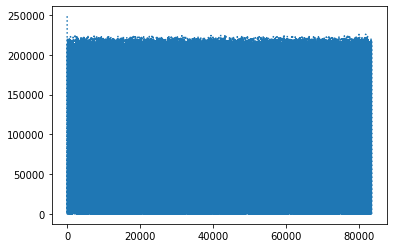

In [19]:
optimizer = RMSpropOptimizer()
params = { "lr": 1e1, "decay_rate": 0.99 }
perform_experiment(optimizer, params);

# Adam

In [20]:
class Adam(SGDOptimizer):
    def __init__(self, eps=1e-8):
        self.eps = eps
        
        self.slope_momentum = self.intercept_momentum = 0
        self.slope_squared_grads = self.intercept_squared_grads = 0
    
    def step(self, model, grad_slope, grad_intercept, params):
        lr = params["lr"]
        beta1, beta2 = params["betas"]
        step = params["step"]
        
        self.slope_momentum = beta1 * self.slope_momentum + (1 - beta1) * grad_slope
        slope_corrected_momentum = self.slope_momentum / (1 - beta1 ** step)
        self.slope_squared_grads = beta2 * self.slope_squared_grads + (1 - beta2) * grad_slope ** 2
        slope_corrected_squared_grads = self.slope_squared_grads / (1 - beta2 ** step)
        model.slope -= lr * slope_corrected_momentum / (np.sqrt(slope_corrected_squared_grads) + self.eps)

        self.intercept_momentum = beta1 * self.intercept_momentum + (1 - beta1) * grad_intercept
        intercept_corrected_momentum = self.intercept_momentum / (1 - beta1 ** step)
        self.intercept_squared_grads = beta2 * self.intercept_squared_grads + (1 - beta2) * grad_intercept ** 2
        intercept_corrected_squared_grads = self.intercept_squared_grads / (1 - beta2 ** step)
        model.intercept -= lr * intercept_corrected_momentum / (np.sqrt(intercept_corrected_squared_grads) + self.eps)


Epochs: 2848
Batches (of size 1): 284800
Slope: -1.9999980335219065
Intercept: 9.999814585095613


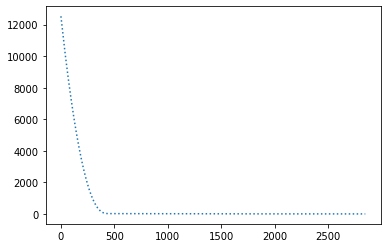

In [21]:
optimizer = Adam()
params = { "lr": 1e-4, "betas": (0.9, 0.999) }
perform_experiment(optimizer, params);

Epochs: 10
Batches (of size 1): 1000
Slope: -2.00000001786048
Intercept: 10.000001361061178


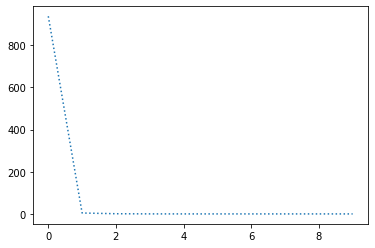

In [22]:
optimizer = Adam()
params = { "lr": 1e0, "betas": (0.9, 0.999) }
perform_experiment(optimizer, params);

Adam seems to be of the order of 10 times faster than other optimization methods and works with much greater learning rates

Epochs: 43
Batches (of size 1): 4300
Slope: -2.000001151784137
Intercept: 9.999987336010909


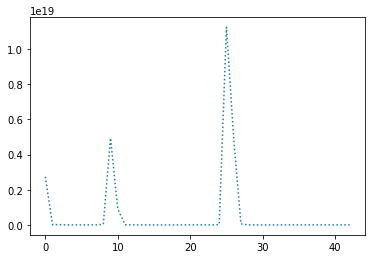

In [23]:
optimizer = Adam()
params = { "lr": 1e8, "betas": (0.9, 0.999) }
perform_experiment(optimizer, params);

In this very easy case of parameters of a linear curve estimation it works with learning rates as large as `1e8`, whereas the largest learning rate that still works among other methods is `1e1` for RMSprop. However, the graphs there showed that oscillations in the error were all over the place, while Adam barely oscillated at all.

Epochs: 72
Batches (of size 1): 7200
Slope: -2.0
Intercept: 10.0


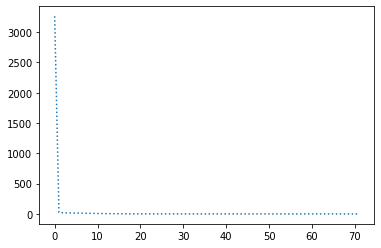

In [24]:
optimizer = Adam()
params = { "lr": 6e-2, "betas": (0.9, 0.999) }
perform_experiment(optimizer, params, 1e-32);

Also, Adam is the only optimizer that was able to achieve an error as little as `1e-32`. Even though out of the box the number of steps (in epochs) was of the same order as for other optimization methods, some hyperparameter tinkering allowed to top them by reducing the number of steps to 72. 